# Physics Constrained Autoencoders

By Mary Ye$^1$, Joshua C. Agar$^2$


$^1$ Department of Computer Science and Engineering, Lehigh University
$^2$ Department of Mechanical Engineering and Mechanics, Drexel University

- There are many times where you want to fit spectroscopic data to a model


- Classical fitting methods can be used but break down:
  - When data is noisy
  - There are multiple candidate models
  - Data is high velocity
  - Data is noisy


## Imports Packages


In [1]:
!pip install m3_learning --no-deps
!pip install -r ../tutorial_requirements.txt


In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import os
from torch.utils.data import Dataset, DataLoader
import time

from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn
from m3_learning.util.rand_util import rand_tensor
from m3_learning.viz.style import set_style
from m3_learning.nn.random import random_seed
set_style("printing")
random_seed(seed=42)

2023-11-10 16:31:12.399257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 16:31:12.433163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 16:31:12.433192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 16:31:12.433227: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 16:31:12.440970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

2023-11-10 16:31:13.124180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Generating some data based on the image


### Define a non-linear function

<center> $$ y = A sin(2\theta f+ \phi)$$ </center>


In [3]:
class Sin_func:

    """
    Class that computes the Sin function
    """

    def __init__(
        self,
        x_vector,
        amp=[0, 1],
        phase=[0, 1],
        frequency=[0, 1],
        size=(1, 1),
        batch_size=1000,
        verbose=False,
    ):
        """

        Args:
            x_vector:
            sd (array, float): range for the standard deviation
            mean (array, float): range for the mean
            amp (array, float): range for the amplitude
            size (tuple): Size of the array first index is number of channels, second is number of functions
            verbose (bool): shows outputs
        """

        self.x_vector = x_vector
        self.batch_size = batch_size

        # computes the scaling of the parameters so the model predicts values in a range from -1 to 1 with a std of 1
        self.amp = amp
        self.amp_mean = torch.tensor(amp[0] + amp[1]) / 2
        self.amp_sd = torch.sqrt(
            torch.pow(torch.tensor(amp[1]) - torch.tensor(amp[0]), 2) / 12
        )

        self.phase = phase
        self.phase_mean = torch.tensor(phase[0] + phase[1]) / 2
        self.phase_sd = torch.sqrt(
            torch.pow(torch.tensor(phase[1]) - torch.tensor(phase[0]), 2) / 12
        )

        self.frequency = frequency
        self.frequency_mean = torch.tensor(frequency[0] + frequency[1]) / 2
        self.frequency_sd = torch.sqrt(
            torch.pow(torch.tensor(frequency[1]) -
                      torch.tensor(frequency[0]), 2) / 12
        )

        self.size = size
        self.verbose = verbose

    def compute(self, params, device="cpu"):
        """

        Args:
            self (object): Returns the instance itself.
            device (string, optional) : Sets the device to do the computation. Default `cpu`, common option `cuda`

        Returns: out (Tensor): spectra.

        """
        
        #computes the function

        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros(
            (params.shape[0], self.x_vector.shape[0],
             self.size[0], self.size[1])
        )

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _amp = params[:, 0, 0, i]
                _phase = params[:, 0, 1, i]
                _frequency = params[:, 0, 2, i]

            if params.ndim == 3:
                _amp = params[:, 0, i]
                _phase = params[:, 1, i]
                _frequency = params[:, 2, i]

            x_vector = (
                torch.cat(params.shape[0] * [self.x_vector])
                .reshape(params.shape[0], -1)
                .to(device)
            )
            x_vector = torch.transpose(x_vector, 0, 1)  # .to(device)

            _out = _amp * torch.sin(
                2 * torch.tensor(np.pi) * _frequency * x_vector + _phase
            )

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)

    def sampler(self, device="cpu"):
        """

        Args:
            device (str): device where computation happens

        Returns:
            out (Tensor) : Generated spectra
            params (Tensor) : parameters used for generation

        """

        phase = rand_tensor(
            min=self.phase[0],
            max=self.phase[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        frequency = rand_tensor(
            min=self.frequency[0],
            max=self.frequency[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        amp = rand_tensor(
            min=self.amp[0],
            max=self.amp[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        _params = torch.torch.stack((amp, phase, frequency))

        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)

        return (self.compute(_params, device=device), _params)


In [4]:
constructor = Sin_func(
    amp=[0.2, 1],  # Sets the amplitude
    phase=[0, 2 * np.pi],  # Sets the phase
    frequency=[0.1, 0.5],  # Sets the frequency
    x_vector=torch.linspace(0, np.pi, 100),  # Sets the x_vector
    batch_size=10000,
)  # number of samples to generate


In [5]:
# initializes the constructor
output = constructor.sampler()

# grabs the parameters and the spectra
spectra, params = output

# This grabs the sum of all spectral and the individual spectra if they exist
spectra_full, spectras = spectra


## Visualize examples


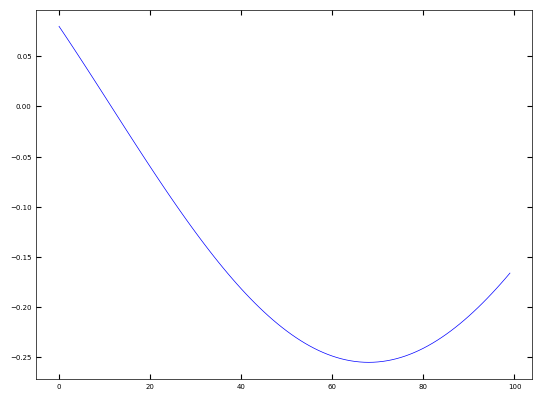

In [6]:
rand = np.random.randint(0, 10000)
plt.plot(spectras[rand, :, 0].cpu(), "b")


## Recurrent Neural Network Autoencoders

- It is important to consider the temporal domain
- This can be improved by using a recurrent neural network that processes each time step sequentially.
- To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.


![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/Autoencoder_Med.png?raw=true)


![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/LSTM%20Node.png?raw=true)


### Builds the autoencoder


In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 100, 1])
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [8]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        # encode

        embedding = self.encoder(x)

        # decode

        predicted = self.decoder(embedding)

        return predicted


Since we know there are intrinsically 3 latent dimensions let's try and train the model.


In [9]:
# checks if cuda is available
print(torch.cuda.is_available())

if torch.cuda.is_available():
    # Assigns device to cuda
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
latent_dim = 3

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


True


In [10]:
# views the model

model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Builds the dataloader


In [11]:
# constructs a dataloader for training

dataloader = DataLoader(spectra_full, batch_size=512,
                        shuffle=True, num_workers=0)


In [12]:
# trains the model

random_seed(seed=42)

Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:06,  2.72it/s]

 60%|██████    | 12/20 [00:00<00:00, 32.29it/s]

100%|██████████| 20/20 [00:00<00:00, 38.03it/s]

Epoch 0, Train Loss: 0.2216
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 76.15it/s]

100%|██████████| 20/20 [00:00<00:00, 105.79it/s]

Epoch 1, Train Loss: 0.2196
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 86.89it/s]

 90%|█████████ | 18/20 [00:00<00:00, 81.14it/s]

100%|██████████| 20/20 [00:00<00:00, 79.18it/s]

Epoch 2, Train Loss: 0.2179
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 126.63it/s]

100%|██████████| 20/20 [00:00<00:00, 98.52it/s] 

Epoch 3, Train Loss: 0.2167
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 61.46it/s]

 70%|███████   | 14/20 [00:00<00:00, 60.95it/s]

100%|██████████| 20/20 [00:00<00:00, 60.68it/s]

Epoch 4, Train Loss: 0.2155
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 98.02it/s]

100%|██████████| 20/20 [00:00<00:00, 116.68it/s]

Epoch 5, Train Loss: 0.2139
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 138.65it/s]

100%|██████████| 20/20 [00:00<00:00, 140.32it/s]

Epoch 6, Train Loss: 0.2130
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.00it/s]

100%|██████████| 20/20 [00:00<00:00, 154.83it/s]

Epoch 7, Train Loss: 0.2124
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.15it/s]

100%|██████████| 20/20 [00:00<00:00, 155.24it/s]

Epoch 8, Train Loss: 0.2115
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.72it/s]

100%|██████████| 20/20 [00:00<00:00, 161.74it/s]

Epoch 9, Train Loss: 0.2111
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.92it/s]

100%|██████████| 20/20 [00:00<00:00, 160.50it/s]

Epoch 10, Train Loss: 0.2103
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 104.07it/s]

100%|██████████| 20/20 [00:00<00:00, 123.16it/s]

Epoch 11, Train Loss: 0.2098
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 147.31it/s]

100%|██████████| 20/20 [00:00<00:00, 133.71it/s]

Epoch 12, Train Loss: 0.2097
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 129.39it/s]

100%|██████████| 20/20 [00:00<00:00, 138.56it/s]

Epoch 13, Train Loss: 0.2091
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.24it/s]

100%|██████████| 20/20 [00:00<00:00, 159.92it/s]

Epoch 14, Train Loss: 0.2087
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.18it/s]

100%|██████████| 20/20 [00:00<00:00, 159.23it/s]

Epoch 15, Train Loss: 0.2087
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 151.57it/s]

100%|██████████| 20/20 [00:00<00:00, 133.69it/s]

Epoch 16, Train Loss: 0.2086
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.55it/s]

100%|██████████| 20/20 [00:00<00:00, 122.60it/s]

Epoch 17, Train Loss: 0.2084
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.41it/s]

100%|██████████| 20/20 [00:00<00:00, 160.49it/s]

Epoch 18, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.43it/s]

100%|██████████| 20/20 [00:00<00:00, 158.53it/s]

Epoch 19, Train Loss: 0.2084
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 117.67it/s]

100%|██████████| 20/20 [00:00<00:00, 132.30it/s]

Epoch 20, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 109.48it/s]

100%|██████████| 20/20 [00:00<00:00, 86.54it/s] 

Epoch 21, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.77it/s]

100%|██████████| 20/20 [00:00<00:00, 120.87it/s]

Epoch 22, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 106.17it/s]

100%|██████████| 20/20 [00:00<00:00, 110.82it/s]

Epoch 23, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 69.61it/s]

 70%|███████   | 14/20 [00:00<00:00, 63.14it/s]

100%|██████████| 20/20 [00:00<00:00, 63.95it/s]

Epoch 24, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 69.59it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 63.10it/s]

100%|██████████| 20/20 [00:00<00:00, 62.96it/s]

Epoch 25, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 67.55it/s]

 70%|███████   | 14/20 [00:00<00:00, 64.88it/s]

100%|██████████| 20/20 [00:00<00:00, 62.83it/s]

Epoch 26, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 61.69it/s]

 70%|███████   | 14/20 [00:00<00:00, 61.16it/s]

100%|██████████| 20/20 [00:00<00:00, 63.51it/s]

Epoch 27, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 137.86it/s]

100%|██████████| 20/20 [00:00<00:00, 143.00it/s]

Epoch 28, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.95it/s]

100%|██████████| 20/20 [00:00<00:00, 153.09it/s]

Epoch 29, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 65.16it/s]

100%|██████████| 20/20 [00:00<00:00, 98.62it/s]

Epoch 30, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.89it/s]

100%|██████████| 20/20 [00:00<00:00, 157.07it/s]

Epoch 31, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.29it/s]

100%|██████████| 20/20 [00:00<00:00, 158.83it/s]

Epoch 32, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.94it/s]

100%|██████████| 20/20 [00:00<00:00, 159.02it/s]

Epoch 33, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 144.02it/s]

100%|██████████| 20/20 [00:00<00:00, 146.42it/s]

Epoch 34, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 159.82it/s]

100%|██████████| 20/20 [00:00<00:00, 156.04it/s]

Epoch 35, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 63.69it/s]

100%|██████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 36, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.81it/s]

100%|██████████| 20/20 [00:00<00:00, 156.53it/s]

Epoch 37, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 149.93it/s]

100%|██████████| 20/20 [00:00<00:00, 151.30it/s]

Epoch 38, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.27it/s]

100%|██████████| 20/20 [00:00<00:00, 158.96it/s]

Epoch 39, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.20it/s]

100%|██████████| 20/20 [00:00<00:00, 153.63it/s]

Epoch 40, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.80it/s]

100%|██████████| 20/20 [00:00<00:00, 154.55it/s]

Epoch 41, Train Loss: 0.2074
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 129.43it/s]

100%|██████████| 20/20 [00:00<00:00, 101.17it/s]

Epoch 42, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 109.60it/s]

100%|██████████| 20/20 [00:00<00:00, 88.84it/s] 

Epoch 43, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.73it/s]

100%|██████████| 20/20 [00:00<00:00, 161.00it/s]

Epoch 44, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.64it/s]

100%|██████████| 20/20 [00:00<00:00, 157.80it/s]

Epoch 45, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.17it/s]

100%|██████████| 20/20 [00:00<00:00, 156.06it/s]

Epoch 46, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 153.21it/s]

100%|██████████| 20/20 [00:00<00:00, 156.33it/s]

Epoch 47, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.65it/s]

100%|██████████| 20/20 [00:00<00:00, 159.27it/s]

Epoch 48, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.54it/s]

100%|██████████| 20/20 [00:00<00:00, 157.45it/s]

Epoch 49, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.41it/s]

100%|██████████| 20/20 [00:00<00:00, 160.94it/s]

Epoch 50, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 155.88it/s]

100%|██████████| 20/20 [00:00<00:00, 156.31it/s]

Epoch 51, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.03it/s]

100%|██████████| 20/20 [00:00<00:00, 162.77it/s]

Epoch 52, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 152.70it/s]

100%|██████████| 20/20 [00:00<00:00, 123.04it/s]

Epoch 53, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 62.85it/s]

 70%|███████   | 14/20 [00:00<00:00, 60.02it/s]

100%|██████████| 20/20 [00:00<00:00, 59.42it/s]

Epoch 54, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.18it/s]

100%|██████████| 20/20 [00:00<00:00, 105.93it/s]

Epoch 55, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 65.67it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 96.49it/s]

100%|██████████| 20/20 [00:00<00:00, 91.84it/s]

Epoch 56, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.09it/s]

100%|██████████| 20/20 [00:00<00:00, 160.47it/s]

Epoch 57, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.26it/s]

100%|██████████| 20/20 [00:00<00:00, 157.86it/s]

Epoch 58, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 143.82it/s]

100%|██████████| 20/20 [00:00<00:00, 113.24it/s]

Epoch 59, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 147.37it/s]

100%|██████████| 20/20 [00:00<00:00, 148.21it/s]

Epoch 60, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.38it/s]

100%|██████████| 20/20 [00:00<00:00, 156.03it/s]

Epoch 61, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 104.41it/s]

100%|██████████| 20/20 [00:00<00:00, 124.92it/s]

Epoch 62, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 106.88it/s]

100%|██████████| 20/20 [00:00<00:00, 125.64it/s]

Epoch 63, Train Loss: 0.2081
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.65it/s]

100%|██████████| 20/20 [00:00<00:00, 159.34it/s]

Epoch 64, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.77it/s]

100%|██████████| 20/20 [00:00<00:00, 158.87it/s]

Epoch 65, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.81it/s]

100%|██████████| 20/20 [00:00<00:00, 159.95it/s]

Epoch 66, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.12it/s]

100%|██████████| 20/20 [00:00<00:00, 157.06it/s]

Epoch 67, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.84it/s]

100%|██████████| 20/20 [00:00<00:00, 160.07it/s]

Epoch 68, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.72it/s]

100%|██████████| 20/20 [00:00<00:00, 159.37it/s]

Epoch 69, Train Loss: 0.2082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.78it/s]

100%|██████████| 20/20 [00:00<00:00, 153.79it/s]

Epoch 70, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 154.07it/s]

100%|██████████| 20/20 [00:00<00:00, 156.26it/s]

Epoch 71, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.44it/s]

100%|██████████| 20/20 [00:00<00:00, 158.86it/s]

Epoch 72, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 103.95it/s]

100%|██████████| 20/20 [00:00<00:00, 116.90it/s]

Epoch 73, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 159.99it/s]

100%|██████████| 20/20 [00:00<00:00, 144.53it/s]

Epoch 74, Train Loss: 0.2083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 64.66it/s]

 70%|███████   | 14/20 [00:00<00:00, 62.39it/s]

100%|██████████| 20/20 [00:00<00:00, 67.89it/s]

Epoch 75, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.20it/s]

100%|██████████| 20/20 [00:00<00:00, 160.16it/s]

Epoch 76, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.45it/s]

100%|██████████| 20/20 [00:00<00:00, 158.91it/s]

Epoch 77, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.37it/s]

100%|██████████| 20/20 [00:00<00:00, 117.37it/s]

Epoch 78, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 64.47it/s]

 70%|███████   | 14/20 [00:00<00:00, 60.35it/s]

100%|██████████| 20/20 [00:00<00:00, 60.80it/s]

Epoch 79, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 57.80it/s]

100%|██████████| 20/20 [00:00<00:00, 98.16it/s]

Epoch 80, Train Loss: 0.2079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.20it/s]

100%|██████████| 20/20 [00:00<00:00, 161.24it/s]

Epoch 81, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.04it/s]

100%|██████████| 20/20 [00:00<00:00, 158.34it/s]

Epoch 82, Train Loss: 0.2078
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 132.15it/s]

100%|██████████| 20/20 [00:00<00:00, 102.44it/s]

Epoch 83, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 59.22it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 60.18it/s]

100%|██████████| 20/20 [00:00<00:00, 60.97it/s]

100%|██████████| 20/20 [00:00<00:00, 60.41it/s]

Epoch 84, Train Loss: 0.2075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 133.42it/s]

100%|██████████| 20/20 [00:00<00:00, 138.53it/s]

Epoch 85, Train Loss: 0.2080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 127.51it/s]

100%|██████████| 20/20 [00:00<00:00, 128.15it/s]

Epoch 86, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 152.85it/s]

100%|██████████| 20/20 [00:00<00:00, 153.16it/s]

Epoch 87, Train Loss: 0.2077
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 167.86it/s]

100%|██████████| 20/20 [00:00<00:00, 163.09it/s]

Epoch 88, Train Loss: 0.2076
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 135.68it/s]

100%|██████████| 20/20 [00:00<00:00, 130.08it/s]

Epoch 89, Train Loss: 0.2074
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 115.61it/s]

100%|██████████| 20/20 [00:00<00:00, 89.32it/s] 

Epoch 90, Train Loss: 0.2072
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.98it/s]

100%|██████████| 20/20 [00:00<00:00, 126.57it/s]

Epoch 91, Train Loss: 0.2070
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.42it/s]

100%|██████████| 20/20 [00:00<00:00, 159.11it/s]

Epoch 92, Train Loss: 0.2072
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.37it/s]

100%|██████████| 20/20 [00:00<00:00, 159.43it/s]

Epoch 93, Train Loss: 0.2068
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 124.60it/s]

100%|██████████| 20/20 [00:00<00:00, 108.13it/s]

Epoch 94, Train Loss: 0.2068
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.09it/s]

100%|██████████| 20/20 [00:00<00:00, 158.89it/s]

Epoch 95, Train Loss: 0.2069
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 155.24it/s]

100%|██████████| 20/20 [00:00<00:00, 149.47it/s]

Epoch 96, Train Loss: 0.2068
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 68.26it/s]

 80%|████████  | 16/20 [00:00<00:00, 79.02it/s]

100%|██████████| 20/20 [00:00<00:00, 85.60it/s]

Epoch 97, Train Loss: 0.2069
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 114.26it/s]

100%|██████████| 20/20 [00:00<00:00, 92.13it/s] 

Epoch 98, Train Loss: 0.2062
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 62.30it/s]

 70%|███████   | 14/20 [00:00<00:00, 60.06it/s]

100%|██████████| 20/20 [00:00<00:00, 60.05it/s]

Epoch 99, Train Loss: 0.2060
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 58.03it/s]

 60%|██████    | 12/20 [00:00<00:00, 58.24it/s]

100%|██████████| 20/20 [00:00<00:00, 66.90it/s]

Epoch 100, Train Loss: 0.2055
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 69.63it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 89.28it/s]

100%|██████████| 20/20 [00:00<00:00, 87.16it/s]

Epoch 101, Train Loss: 0.2061
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.97it/s]

100%|██████████| 20/20 [00:00<00:00, 153.10it/s]

Epoch 102, Train Loss: 0.2053
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 61.17it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 80.48it/s]

100%|██████████| 20/20 [00:00<00:00, 83.79it/s]

Epoch 103, Train Loss: 0.2055
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 104.72it/s]

100%|██████████| 20/20 [00:00<00:00, 96.18it/s] 

Epoch 104, Train Loss: 0.2050
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.72it/s]

100%|██████████| 20/20 [00:00<00:00, 150.87it/s]

Epoch 105, Train Loss: 0.2044
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.49it/s]

100%|██████████| 20/20 [00:00<00:00, 139.03it/s]

Epoch 106, Train Loss: 0.2043
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 60.90it/s]

 70%|███████   | 14/20 [00:00<00:00, 60.82it/s]

100%|██████████| 20/20 [00:00<00:00, 62.74it/s]

Epoch 107, Train Loss: 0.2039
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 66.76it/s]

100%|██████████| 20/20 [00:00<00:00, 104.27it/s]

Epoch 108, Train Loss: 0.2031
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 95.69it/s]

100%|██████████| 20/20 [00:00<00:00, 119.91it/s]

Epoch 109, Train Loss: 0.2027
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.49it/s]

100%|██████████| 20/20 [00:00<00:00, 156.18it/s]

Epoch 110, Train Loss: 0.2025
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 74.74it/s]

 80%|████████  | 16/20 [00:00<00:00, 71.83it/s]

100%|██████████| 20/20 [00:00<00:00, 80.69it/s]

Epoch 111, Train Loss: 0.2021
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 142.16it/s]

100%|██████████| 20/20 [00:00<00:00, 146.28it/s]

Epoch 112, Train Loss: 0.2018
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.64it/s]

100%|██████████| 20/20 [00:00<00:00, 156.92it/s]

Epoch 113, Train Loss: 0.2012
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.29it/s]

100%|██████████| 20/20 [00:00<00:00, 145.39it/s]

Epoch 114, Train Loss: 0.2009
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.64it/s]

100%|██████████| 20/20 [00:00<00:00, 158.14it/s]

Epoch 115, Train Loss: 0.2003
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 149.59it/s]

100%|██████████| 20/20 [00:00<00:00, 119.24it/s]

Epoch 116, Train Loss: 0.2002
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 59.48it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 61.52it/s]

100%|██████████| 20/20 [00:00<00:00, 67.96it/s]

Epoch 117, Train Loss: 0.2000
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 68.86it/s]

100%|██████████| 20/20 [00:00<00:00, 96.14it/s]

Epoch 118, Train Loss: 0.1991
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 86.14it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 68.55it/s]

100%|██████████| 20/20 [00:00<00:00, 69.98it/s]

Epoch 119, Train Loss: 0.1990
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 61.80it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 70.27it/s]

100%|██████████| 20/20 [00:00<00:00, 72.93it/s]

Epoch 120, Train Loss: 0.1984
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 103.00it/s]

100%|██████████| 20/20 [00:00<00:00, 120.71it/s]

Epoch 121, Train Loss: 0.1984
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 129.84it/s]

100%|██████████| 20/20 [00:00<00:00, 106.48it/s]

Epoch 122, Train Loss: 0.1978
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 64.19it/s]

 80%|████████  | 16/20 [00:00<00:00, 78.29it/s]

100%|██████████| 20/20 [00:00<00:00, 77.27it/s]

Epoch 123, Train Loss: 0.1979
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 67.89it/s]

 80%|████████  | 16/20 [00:00<00:00, 79.02it/s]

100%|██████████| 20/20 [00:00<00:00, 84.74it/s]

Epoch 124, Train Loss: 0.1981
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████| 20/20 [00:00<00:00, 122.25it/s]

Epoch 125, Train Loss: 0.1976
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 74.96it/s]

 80%|████████  | 16/20 [00:00<00:00, 68.45it/s]

100%|██████████| 20/20 [00:00<00:00, 76.49it/s]

Epoch 126, Train Loss: 0.1968
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.83it/s]

100%|██████████| 20/20 [00:00<00:00, 159.62it/s]

Epoch 127, Train Loss: 0.1947
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.37it/s]

100%|██████████| 20/20 [00:00<00:00, 160.97it/s]

Epoch 128, Train Loss: 0.1929
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.57it/s]

100%|██████████| 20/20 [00:00<00:00, 162.35it/s]

Epoch 129, Train Loss: 0.1916
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.33it/s]

100%|██████████| 20/20 [00:00<00:00, 157.64it/s]

Epoch 130, Train Loss: 0.1907
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.67it/s]

100%|██████████| 20/20 [00:00<00:00, 155.76it/s]

Epoch 131, Train Loss: 0.1899
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 143.24it/s]

100%|██████████| 20/20 [00:00<00:00, 144.57it/s]

Epoch 132, Train Loss: 0.1897
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 126.04it/s]

100%|██████████| 20/20 [00:00<00:00, 121.96it/s]

Epoch 133, Train Loss: 0.1897
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.69it/s]

100%|██████████| 20/20 [00:00<00:00, 161.50it/s]

Epoch 134, Train Loss: 0.1888
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.01it/s]

100%|██████████| 20/20 [00:00<00:00, 160.91it/s]

Epoch 135, Train Loss: 0.1889
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 119.66it/s]

100%|██████████| 20/20 [00:00<00:00, 127.13it/s]

Epoch 136, Train Loss: 0.1887
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.90it/s]

100%|██████████| 20/20 [00:00<00:00, 155.39it/s]

Epoch 137, Train Loss: 0.1891
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.90it/s]

100%|██████████| 20/20 [00:00<00:00, 159.55it/s]

Epoch 138, Train Loss: 0.1882
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.73it/s]

100%|██████████| 20/20 [00:00<00:00, 134.65it/s]

Epoch 139, Train Loss: 0.1887
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.77it/s]

100%|██████████| 20/20 [00:00<00:00, 135.05it/s]

Epoch 140, Train Loss: 0.1882
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.01it/s]

100%|██████████| 20/20 [00:00<00:00, 157.29it/s]

Epoch 141, Train Loss: 0.1881
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.74it/s]

100%|██████████| 20/20 [00:00<00:00, 161.60it/s]

Epoch 142, Train Loss: 0.1879
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.75it/s]

100%|██████████| 20/20 [00:00<00:00, 161.75it/s]

Epoch 143, Train Loss: 0.1875
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 147.34it/s]

100%|██████████| 20/20 [00:00<00:00, 147.56it/s]

Epoch 144, Train Loss: 0.1877
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 132.61it/s]

100%|██████████| 20/20 [00:00<00:00, 138.21it/s]

Epoch 145, Train Loss: 0.1868
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 108.41it/s]

100%|██████████| 20/20 [00:00<00:00, 89.64it/s] 

Epoch 146, Train Loss: 0.1867
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 71.24it/s]

100%|██████████| 20/20 [00:00<00:00, 103.26it/s]

Epoch 147, Train Loss: 0.1865
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 125.99it/s]

100%|██████████| 20/20 [00:00<00:00, 133.63it/s]

Epoch 148, Train Loss: 0.1860
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 79.07it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 67.61it/s]

100%|██████████| 20/20 [00:00<00:00, 68.53it/s]

Epoch 149, Train Loss: 0.1858
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 61.95it/s]

 70%|███████   | 14/20 [00:00<00:00, 62.57it/s]

100%|██████████| 20/20 [00:00<00:00, 61.47it/s]

Epoch 150, Train Loss: 0.1858
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 69.62it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 65.02it/s]

100%|██████████| 20/20 [00:00<00:00, 65.19it/s]

Epoch 151, Train Loss: 0.1855
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 63.00it/s]

 70%|███████   | 14/20 [00:00<00:00, 62.59it/s]

100%|██████████| 20/20 [00:00<00:00, 61.80it/s]

Epoch 152, Train Loss: 0.1854
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 57.98it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 61.37it/s]

100%|██████████| 20/20 [00:00<00:00, 68.25it/s]

Epoch 153, Train Loss: 0.1855
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 142.74it/s]

100%|██████████| 20/20 [00:00<00:00, 145.22it/s]

Epoch 154, Train Loss: 0.1848
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 155.57it/s]

100%|██████████| 20/20 [00:00<00:00, 153.42it/s]

Epoch 155, Train Loss: 0.1847
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.05it/s]

100%|██████████| 20/20 [00:00<00:00, 158.24it/s]

Epoch 156, Train Loss: 0.1843
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 144.10it/s]

100%|██████████| 20/20 [00:00<00:00, 143.67it/s]

Epoch 157, Train Loss: 0.1839
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 140.56it/s]

100%|██████████| 20/20 [00:00<00:00, 143.15it/s]

Epoch 158, Train Loss: 0.1837
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.86it/s]

100%|██████████| 20/20 [00:00<00:00, 161.14it/s]

Epoch 159, Train Loss: 0.1839
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.34it/s]

100%|██████████| 20/20 [00:00<00:00, 118.97it/s]

Epoch 160, Train Loss: 0.1838
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.02it/s]

100%|██████████| 20/20 [00:00<00:00, 160.82it/s]

Epoch 161, Train Loss: 0.1834
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 152.71it/s]

100%|██████████| 20/20 [00:00<00:00, 153.00it/s]

Epoch 162, Train Loss: 0.1831
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 154.09it/s]

100%|██████████| 20/20 [00:00<00:00, 153.31it/s]

Epoch 163, Train Loss: 0.1827
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 148.96it/s]

100%|██████████| 20/20 [00:00<00:00, 149.65it/s]

Epoch 164, Train Loss: 0.1833
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 154.96it/s]

100%|██████████| 20/20 [00:00<00:00, 152.35it/s]

Epoch 165, Train Loss: 0.1829
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.85it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 94.26it/s]

100%|██████████| 20/20 [00:00<00:00, 94.33it/s]

Epoch 166, Train Loss: 0.1828
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 67.96it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 84.81it/s]

100%|██████████| 20/20 [00:00<00:00, 88.29it/s]

Epoch 167, Train Loss: 0.1822
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 75.51it/s]

100%|██████████| 20/20 [00:00<00:00, 107.09it/s]

Epoch 168, Train Loss: 0.1818
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.46it/s]

100%|██████████| 20/20 [00:00<00:00, 161.50it/s]

Epoch 169, Train Loss: 0.1822
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.03it/s]

100%|██████████| 20/20 [00:00<00:00, 128.55it/s]

Epoch 170, Train Loss: 0.1814
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 125.76it/s]

100%|██████████| 20/20 [00:00<00:00, 136.04it/s]

Epoch 171, Train Loss: 0.1817
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.45it/s]

100%|██████████| 20/20 [00:00<00:00, 159.79it/s]

Epoch 172, Train Loss: 0.1814
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 126.41it/s]

100%|██████████| 20/20 [00:00<00:00, 127.95it/s]

Epoch 173, Train Loss: 0.1812
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.85it/s]

100%|██████████| 20/20 [00:00<00:00, 159.24it/s]

Epoch 174, Train Loss: 0.1812
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.50it/s]

100%|██████████| 20/20 [00:00<00:00, 155.86it/s]

Epoch 175, Train Loss: 0.1814
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.44it/s]

100%|██████████| 20/20 [00:00<00:00, 88.76it/s] 

Epoch 176, Train Loss: 0.1808
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.84it/s]

100%|██████████| 20/20 [00:00<00:00, 122.23it/s]

Epoch 177, Train Loss: 0.1807
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.05it/s]

100%|██████████| 20/20 [00:00<00:00, 159.82it/s]

Epoch 178, Train Loss: 0.1808
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.06it/s]

100%|██████████| 20/20 [00:00<00:00, 158.47it/s]

Epoch 179, Train Loss: 0.1806
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 116.04it/s]

100%|██████████| 20/20 [00:00<00:00, 121.95it/s]

Epoch 180, Train Loss: 0.1803
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.04it/s]

100%|██████████| 20/20 [00:00<00:00, 161.45it/s]

Epoch 181, Train Loss: 0.1804
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.94it/s]

100%|██████████| 20/20 [00:00<00:00, 160.50it/s]

Epoch 182, Train Loss: 0.1805
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 134.03it/s]

100%|██████████| 20/20 [00:00<00:00, 124.98it/s]

Epoch 183, Train Loss: 0.1801
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 137.88it/s]

100%|██████████| 20/20 [00:00<00:00, 141.05it/s]

Epoch 184, Train Loss: 0.1801
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.53it/s]

100%|██████████| 20/20 [00:00<00:00, 153.69it/s]

Epoch 185, Train Loss: 0.1799
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.18it/s]

100%|██████████| 20/20 [00:00<00:00, 155.63it/s]

Epoch 186, Train Loss: 0.1795
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 139.45it/s]

100%|██████████| 20/20 [00:00<00:00, 144.66it/s]

Epoch 187, Train Loss: 0.1795
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.31it/s]

100%|██████████| 20/20 [00:00<00:00, 159.93it/s]

Epoch 188, Train Loss: 0.1799
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 142.41it/s]

100%|██████████| 20/20 [00:00<00:00, 143.73it/s]

Epoch 189, Train Loss: 0.1792
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.10it/s]

100%|██████████| 20/20 [00:00<00:00, 155.91it/s]

Epoch 190, Train Loss: 0.1789
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 144.81it/s]

100%|██████████| 20/20 [00:00<00:00, 124.24it/s]

Epoch 191, Train Loss: 0.1791
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.51it/s]

100%|██████████| 20/20 [00:00<00:00, 157.03it/s]

Epoch 192, Train Loss: 0.1790
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.16it/s]

100%|██████████| 20/20 [00:00<00:00, 164.33it/s]

Epoch 193, Train Loss: 0.1792
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 105.37it/s]

100%|██████████| 20/20 [00:00<00:00, 92.43it/s] 

Epoch 194, Train Loss: 0.1788
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 137.96it/s]

100%|██████████| 20/20 [00:00<00:00, 143.06it/s]

Epoch 195, Train Loss: 0.1786
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 151.53it/s]

100%|██████████| 20/20 [00:00<00:00, 131.65it/s]

Epoch 196, Train Loss: 0.1790
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 85.71it/s]

100%|██████████| 20/20 [00:00<00:00, 116.33it/s]

Epoch 197, Train Loss: 0.1785
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.00it/s]

100%|██████████| 20/20 [00:00<00:00, 159.48it/s]

Epoch 198, Train Loss: 0.1788
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.38it/s]

100%|██████████| 20/20 [00:00<00:00, 157.27it/s]

Epoch 199, Train Loss: 0.1782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 105.59it/s]

100%|██████████| 20/20 [00:00<00:00, 94.35it/s] 

Epoch 200, Train Loss: 0.1785
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 56.79it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 59.24it/s]

100%|██████████| 20/20 [00:00<00:00, 61.41it/s]

100%|██████████| 20/20 [00:00<00:00, 60.38it/s]

Epoch 201, Train Loss: 0.1782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 56.01it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 59.94it/s]

100%|██████████| 20/20 [00:00<00:00, 60.59it/s]

100%|██████████| 20/20 [00:00<00:00, 59.78it/s]

Epoch 202, Train Loss: 0.1782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 77.66it/s]

100%|██████████| 20/20 [00:00<00:00, 107.98it/s]

Epoch 203, Train Loss: 0.1782
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.06it/s]

100%|██████████| 20/20 [00:00<00:00, 157.94it/s]

Epoch 204, Train Loss: 0.1781
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.17it/s]

100%|██████████| 20/20 [00:00<00:00, 160.01it/s]

Epoch 205, Train Loss: 0.1780
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.36it/s]

100%|██████████| 20/20 [00:00<00:00, 158.43it/s]

Epoch 206, Train Loss: 0.1781
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 76.84it/s]

100%|██████████| 20/20 [00:00<00:00, 108.60it/s]

Epoch 207, Train Loss: 0.1778
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.11it/s]

100%|██████████| 20/20 [00:00<00:00, 160.26it/s]

Epoch 208, Train Loss: 0.1779
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.75it/s]

100%|██████████| 20/20 [00:00<00:00, 158.27it/s]

Epoch 209, Train Loss: 0.1779
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 136.91it/s]

100%|██████████| 20/20 [00:00<00:00, 108.98it/s]

Epoch 210, Train Loss: 0.1777
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 75.05it/s]

100%|██████████| 20/20 [00:00<00:00, 110.85it/s]

Epoch 211, Train Loss: 0.1778
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.92it/s]

100%|██████████| 20/20 [00:00<00:00, 159.75it/s]

Epoch 212, Train Loss: 0.1779
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.91it/s]

100%|██████████| 20/20 [00:00<00:00, 158.68it/s]

Epoch 213, Train Loss: 0.1776
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.93it/s]

100%|██████████| 20/20 [00:00<00:00, 160.82it/s]

Epoch 214, Train Loss: 0.1776
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.38it/s]

100%|██████████| 20/20 [00:00<00:00, 157.24it/s]

Epoch 215, Train Loss: 0.1775
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 59.74it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 65.71it/s]

100%|██████████| 20/20 [00:00<00:00, 71.40it/s]

Epoch 216, Train Loss: 0.1772
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 136.83it/s]

100%|██████████| 20/20 [00:00<00:00, 103.47it/s]

Epoch 217, Train Loss: 0.1769
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 88.88it/s]

 90%|█████████ | 18/20 [00:00<00:00, 83.06it/s]

100%|██████████| 20/20 [00:00<00:00, 87.83it/s]

Epoch 218, Train Loss: 0.1768
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.65it/s]

100%|██████████| 20/20 [00:00<00:00, 160.54it/s]

Epoch 219, Train Loss: 0.1773
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 75.61it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 90.31it/s]

100%|██████████| 20/20 [00:00<00:00, 88.43it/s]

Epoch 220, Train Loss: 0.1771
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 126.84it/s]

100%|██████████| 20/20 [00:00<00:00, 111.56it/s]

Epoch 221, Train Loss: 0.1771
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 79.07it/s]

100%|██████████| 20/20 [00:00<00:00, 105.50it/s]

Epoch 222, Train Loss: 0.1767
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 68.40it/s]

 70%|███████   | 14/20 [00:00<00:00, 63.44it/s]

100%|██████████| 20/20 [00:00<00:00, 65.26it/s]

Epoch 223, Train Loss: 0.1770
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 68.77it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 68.14it/s]

100%|██████████| 20/20 [00:00<00:00, 73.16it/s]

Epoch 224, Train Loss: 0.1769
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 155.40it/s]

100%|██████████| 20/20 [00:00<00:00, 147.02it/s]

Epoch 225, Train Loss: 0.1769
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.91it/s]

100%|██████████| 20/20 [00:00<00:00, 159.63it/s]

Epoch 226, Train Loss: 0.1766
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.20it/s]

100%|██████████| 20/20 [00:00<00:00, 153.66it/s]

Epoch 227, Train Loss: 0.1765
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.46it/s]

100%|██████████| 20/20 [00:00<00:00, 160.84it/s]

Epoch 228, Train Loss: 0.1764
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.40it/s]

100%|██████████| 20/20 [00:00<00:00, 158.06it/s]

Epoch 229, Train Loss: 0.1761
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.72it/s]

100%|██████████| 20/20 [00:00<00:00, 158.41it/s]

Epoch 230, Train Loss: 0.1758
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 107.54it/s]

100%|██████████| 20/20 [00:00<00:00, 120.46it/s]

Epoch 231, Train Loss: 0.1757
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 152.01it/s]

100%|██████████| 20/20 [00:00<00:00, 133.76it/s]

Epoch 232, Train Loss: 0.1754
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.86it/s]

100%|██████████| 20/20 [00:00<00:00, 156.12it/s]

Epoch 233, Train Loss: 0.1755
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 145.48it/s]

100%|██████████| 20/20 [00:00<00:00, 147.21it/s]

Epoch 234, Train Loss: 0.1753
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 69.52it/s]

100%|██████████| 20/20 [00:00<00:00, 95.14it/s]

Epoch 235, Train Loss: 0.1752
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 100.85it/s]

100%|██████████| 20/20 [00:00<00:00, 81.87it/s] 

Epoch 236, Train Loss: 0.1745
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 78.01it/s]

100%|██████████| 20/20 [00:00<00:00, 114.97it/s]

Epoch 237, Train Loss: 0.1746
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 145.80it/s]

100%|██████████| 20/20 [00:00<00:00, 133.75it/s]

Epoch 238, Train Loss: 0.1741
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 167.70it/s]

100%|██████████| 20/20 [00:00<00:00, 163.83it/s]

Epoch 239, Train Loss: 0.1734
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 137.29it/s]

100%|██████████| 20/20 [00:00<00:00, 123.04it/s]

Epoch 240, Train Loss: 0.1734
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 123.39it/s]

100%|██████████| 20/20 [00:00<00:00, 96.24it/s] 

Epoch 241, Train Loss: 0.1725
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 78.51it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 84.85it/s]

100%|██████████| 20/20 [00:00<00:00, 77.99it/s]

Epoch 242, Train Loss: 0.1718
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 54.31it/s]

100%|██████████| 20/20 [00:00<00:00, 97.81it/s]

Epoch 243, Train Loss: 0.1714
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 139.75it/s]

100%|██████████| 20/20 [00:00<00:00, 109.16it/s]

Epoch 244, Train Loss: 0.1699
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 72.34it/s]

100%|██████████| 20/20 [00:00<00:00, 102.54it/s]

Epoch 245, Train Loss: 0.1691
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 148.95it/s]

100%|██████████| 20/20 [00:00<00:00, 151.70it/s]

Epoch 246, Train Loss: 0.1675
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.61it/s]

100%|██████████| 20/20 [00:00<00:00, 154.58it/s]

Epoch 247, Train Loss: 0.1660
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 83.50it/s]

100%|██████████| 20/20 [00:00<00:00, 109.45it/s]

Epoch 248, Train Loss: 0.1644
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.68it/s]

100%|██████████| 20/20 [00:00<00:00, 132.98it/s]

Epoch 249, Train Loss: 0.1630
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 146.24it/s]

100%|██████████| 20/20 [00:00<00:00, 147.34it/s]

Epoch 250, Train Loss: 0.1617
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.27it/s]

100%|██████████| 20/20 [00:00<00:00, 164.08it/s]

Epoch 251, Train Loss: 0.1601
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.26it/s]

100%|██████████| 20/20 [00:00<00:00, 161.50it/s]

Epoch 252, Train Loss: 0.1595
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.94it/s]

100%|██████████| 20/20 [00:00<00:00, 140.46it/s]

Epoch 253, Train Loss: 0.1590
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.74it/s]

100%|██████████| 20/20 [00:00<00:00, 132.58it/s]

Epoch 254, Train Loss: 0.1586
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.74it/s]

100%|██████████| 20/20 [00:00<00:00, 155.11it/s]

Epoch 255, Train Loss: 0.1578
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 66.97it/s]

 70%|███████   | 14/20 [00:00<00:00, 65.81it/s]

100%|██████████| 20/20 [00:00<00:00, 78.44it/s]

Epoch 256, Train Loss: 0.1576
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.51it/s]

100%|██████████| 20/20 [00:00<00:00, 149.51it/s]

Epoch 257, Train Loss: 0.1572
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 156.52it/s]

100%|██████████| 20/20 [00:00<00:00, 138.14it/s]

Epoch 258, Train Loss: 0.1569
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 71.15it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 81.14it/s]

100%|██████████| 20/20 [00:00<00:00, 81.25it/s]

Epoch 259, Train Loss: 0.1568
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 68.08it/s]

 70%|███████   | 14/20 [00:00<00:00, 64.79it/s]

100%|██████████| 20/20 [00:00<00:00, 68.13it/s]

Epoch 260, Train Loss: 0.1561
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.56it/s]

100%|██████████| 20/20 [00:00<00:00, 90.88it/s]

100%|██████████| 20/20 [00:00<00:00, 91.43it/s]

Epoch 261, Train Loss: 0.1560
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 72.47it/s]

 80%|████████  | 16/20 [00:00<00:00, 74.34it/s]

100%|██████████| 20/20 [00:00<00:00, 82.43it/s]

Epoch 262, Train Loss: 0.1556
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.41it/s]

100%|██████████| 20/20 [00:00<00:00, 126.65it/s]

Epoch 263, Train Loss: 0.1554
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 139.40it/s]

100%|██████████| 20/20 [00:00<00:00, 144.03it/s]

Epoch 264, Train Loss: 0.1549
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.89it/s]

100%|██████████| 20/20 [00:00<00:00, 163.54it/s]

Epoch 265, Train Loss: 0.1549
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.74it/s]

100%|██████████| 20/20 [00:00<00:00, 164.65it/s]

Epoch 266, Train Loss: 0.1546
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.84it/s]

100%|██████████| 20/20 [00:00<00:00, 158.08it/s]

Epoch 267, Train Loss: 0.1541
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.21it/s]

100%|██████████| 20/20 [00:00<00:00, 161.14it/s]

Epoch 268, Train Loss: 0.1539
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 106.41it/s]

100%|██████████| 20/20 [00:00<00:00, 112.32it/s]

Epoch 269, Train Loss: 0.1536
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 159.83it/s]

100%|██████████| 20/20 [00:00<00:00, 156.51it/s]

Epoch 270, Train Loss: 0.1533
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 70.40it/s]

 80%|████████  | 16/20 [00:00<00:00, 62.87it/s]

100%|██████████| 20/20 [00:00<00:00, 62.68it/s]

Epoch 271, Train Loss: 0.1531
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 55.98it/s]

 60%|██████    | 12/20 [00:00<00:00, 55.62it/s]

 90%|█████████ | 18/20 [00:00<00:00, 56.74it/s]

100%|██████████| 20/20 [00:00<00:00, 56.71it/s]

Epoch 272, Train Loss: 0.1528
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 56.05it/s]

 80%|████████  | 16/20 [00:00<00:00, 80.72it/s]

100%|██████████| 20/20 [00:00<00:00, 85.56it/s]

Epoch 273, Train Loss: 0.1523
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 93.74it/s]

100%|██████████| 20/20 [00:00<00:00, 70.17it/s]

100%|██████████| 20/20 [00:00<00:00, 72.48it/s]

Epoch 274, Train Loss: 0.1525
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 62.50it/s]

 70%|███████   | 14/20 [00:00<00:00, 65.20it/s]

100%|██████████| 20/20 [00:00<00:00, 71.40it/s]

Epoch 275, Train Loss: 0.1525
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 155.52it/s]

100%|██████████| 20/20 [00:00<00:00, 154.43it/s]

Epoch 276, Train Loss: 0.1517
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.86it/s]

100%|██████████| 20/20 [00:00<00:00, 157.61it/s]

Epoch 277, Train Loss: 0.1514
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 62.75it/s]

 90%|█████████ | 18/20 [00:00<00:00, 86.76it/s]

100%|██████████| 20/20 [00:00<00:00, 86.29it/s]

Epoch 278, Train Loss: 0.1515
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.12it/s]

100%|██████████| 20/20 [00:00<00:00, 155.86it/s]

Epoch 279, Train Loss: 0.1508
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 64.24it/s]

 70%|███████   | 14/20 [00:00<00:00, 59.15it/s]

100%|██████████| 20/20 [00:00<00:00, 61.05it/s]

Epoch 280, Train Loss: 0.1505
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 62.15it/s]

 70%|███████   | 14/20 [00:00<00:00, 62.97it/s]

100%|██████████| 20/20 [00:00<00:00, 61.36it/s]

Epoch 281, Train Loss: 0.1506
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 58.17it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 85.88it/s]

100%|██████████| 20/20 [00:00<00:00, 88.25it/s]

Epoch 282, Train Loss: 0.1497
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.80it/s]

100%|██████████| 20/20 [00:00<00:00, 147.35it/s]

Epoch 283, Train Loss: 0.1498
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 117.26it/s]

100%|██████████| 20/20 [00:00<00:00, 111.11it/s]

Epoch 284, Train Loss: 0.1497
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 147.28it/s]

100%|██████████| 20/20 [00:00<00:00, 117.28it/s]

Epoch 285, Train Loss: 0.1495
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 129.19it/s]

100%|██████████| 20/20 [00:00<00:00, 120.95it/s]

Epoch 286, Train Loss: 0.1491
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.70it/s]

100%|██████████| 20/20 [00:00<00:00, 143.19it/s]

Epoch 287, Train Loss: 0.1493
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.94it/s]

100%|██████████| 20/20 [00:00<00:00, 150.48it/s]

Epoch 288, Train Loss: 0.1487
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.04it/s]

100%|██████████| 20/20 [00:00<00:00, 145.81it/s]

Epoch 289, Train Loss: 0.1485
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 138.01it/s]

100%|██████████| 20/20 [00:00<00:00, 117.38it/s]

Epoch 290, Train Loss: 0.1481
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 147.45it/s]

100%|██████████| 20/20 [00:00<00:00, 148.15it/s]

Epoch 291, Train Loss: 0.1477
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 127.83it/s]

100%|██████████| 20/20 [00:00<00:00, 139.50it/s]

Epoch 292, Train Loss: 0.1475
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.85it/s]

100%|██████████| 20/20 [00:00<00:00, 137.26it/s]

Epoch 293, Train Loss: 0.1473
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 105.77it/s]

100%|██████████| 20/20 [00:00<00:00, 126.17it/s]

Epoch 294, Train Loss: 0.1470
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.98it/s]

100%|██████████| 20/20 [00:00<00:00, 148.70it/s]

Epoch 295, Train Loss: 0.1461
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 89.20it/s]

100%|██████████| 20/20 [00:00<00:00, 117.92it/s]

Epoch 296, Train Loss: 0.1466
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.77it/s]

100%|██████████| 20/20 [00:00<00:00, 94.11it/s] 

Epoch 297, Train Loss: 0.1459
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 55.74it/s]

 60%|██████    | 12/20 [00:00<00:00, 58.04it/s]

 90%|█████████ | 18/20 [00:00<00:00, 58.66it/s]

100%|██████████| 20/20 [00:00<00:00, 58.12it/s]

Epoch 298, Train Loss: 0.1459
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 62.93it/s]

 70%|███████   | 14/20 [00:00<00:00, 59.91it/s]

100%|██████████| 20/20 [00:00<00:00, 58.65it/s]

Epoch 299, Train Loss: 0.1453
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 57.09it/s]

 60%|██████    | 12/20 [00:00<00:00, 57.37it/s]

100%|██████████| 20/20 [00:00<00:00, 72.99it/s]

Epoch 300, Train Loss: 0.1451
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 154.89it/s]

100%|██████████| 20/20 [00:00<00:00, 133.72it/s]

Epoch 301, Train Loss: 0.1449
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 138.40it/s]

100%|██████████| 20/20 [00:00<00:00, 137.42it/s]

Epoch 302, Train Loss: 0.1449
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.23it/s]

100%|██████████| 20/20 [00:00<00:00, 161.91it/s]

Epoch 303, Train Loss: 0.1442
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 151.53it/s]

100%|██████████| 20/20 [00:00<00:00, 151.90it/s]

Epoch 304, Train Loss: 0.1441
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 71.22it/s]

 80%|████████  | 16/20 [00:00<00:00, 63.96it/s]

100%|██████████| 20/20 [00:00<00:00, 66.06it/s]

Epoch 305, Train Loss: 0.1438
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 66.88it/s]

 70%|███████   | 14/20 [00:00<00:00, 60.08it/s]

100%|██████████| 20/20 [00:00<00:00, 63.63it/s]

Epoch 306, Train Loss: 0.1434
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.46it/s]

100%|██████████| 20/20 [00:00<00:00, 152.43it/s]

Epoch 307, Train Loss: 0.1433
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 134.86it/s]

100%|██████████| 20/20 [00:00<00:00, 99.37it/s] 

Epoch 308, Train Loss: 0.1430
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 154.95it/s]

100%|██████████| 20/20 [00:00<00:00, 148.38it/s]

Epoch 309, Train Loss: 0.1421
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.47it/s]

100%|██████████| 20/20 [00:00<00:00, 159.06it/s]

Epoch 310, Train Loss: 0.1422
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.80it/s]

100%|██████████| 20/20 [00:00<00:00, 154.85it/s]

Epoch 311, Train Loss: 0.1421
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 148.81it/s]

100%|██████████| 20/20 [00:00<00:00, 148.17it/s]

Epoch 312, Train Loss: 0.1418
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.90it/s]

100%|██████████| 20/20 [00:00<00:00, 129.04it/s]

Epoch 313, Train Loss: 0.1414
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 146.02it/s]

100%|██████████| 20/20 [00:00<00:00, 130.58it/s]

Epoch 314, Train Loss: 0.1411
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.84it/s]

100%|██████████| 20/20 [00:00<00:00, 158.94it/s]

Epoch 315, Train Loss: 0.1407
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.99it/s]

100%|██████████| 20/20 [00:00<00:00, 159.39it/s]

Epoch 316, Train Loss: 0.1403
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 155.47it/s]

100%|██████████| 20/20 [00:00<00:00, 151.85it/s]

Epoch 317, Train Loss: 0.1398
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.79it/s]

100%|██████████| 20/20 [00:00<00:00, 155.44it/s]

Epoch 318, Train Loss: 0.1399
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.15it/s]

100%|██████████| 20/20 [00:00<00:00, 160.32it/s]

Epoch 319, Train Loss: 0.1396
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.87it/s]

100%|██████████| 20/20 [00:00<00:00, 156.98it/s]

Epoch 320, Train Loss: 0.1388
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.46it/s]

100%|██████████| 20/20 [00:00<00:00, 160.11it/s]

Epoch 321, Train Loss: 0.1385
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.14it/s]

100%|██████████| 20/20 [00:00<00:00, 164.96it/s]

Epoch 322, Train Loss: 0.1381
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.76it/s]

100%|██████████| 20/20 [00:00<00:00, 162.07it/s]

Epoch 323, Train Loss: 0.1381
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.44it/s]

100%|██████████| 20/20 [00:00<00:00, 157.29it/s]

Epoch 324, Train Loss: 0.1376
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.12it/s]

100%|██████████| 20/20 [00:00<00:00, 164.27it/s]

Epoch 325, Train Loss: 0.1374
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.03it/s]

100%|██████████| 20/20 [00:00<00:00, 153.48it/s]

Epoch 326, Train Loss: 0.1367
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 134.15it/s]

100%|██████████| 20/20 [00:00<00:00, 135.04it/s]

Epoch 327, Train Loss: 0.1367
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 167.23it/s]

100%|██████████| 20/20 [00:00<00:00, 164.32it/s]

Epoch 328, Train Loss: 0.1360
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.20it/s]

100%|██████████| 20/20 [00:00<00:00, 156.05it/s]

Epoch 329, Train Loss: 0.1358
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.64it/s]

100%|██████████| 20/20 [00:00<00:00, 161.21it/s]

Epoch 330, Train Loss: 0.1355
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.28it/s]

100%|██████████| 20/20 [00:00<00:00, 162.80it/s]

Epoch 331, Train Loss: 0.1351
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.98it/s]

100%|██████████| 20/20 [00:00<00:00, 134.60it/s]

Epoch 332, Train Loss: 0.1345
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.64it/s]

100%|██████████| 20/20 [00:00<00:00, 159.38it/s]

Epoch 333, Train Loss: 0.1342
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 152.33it/s]

100%|██████████| 20/20 [00:00<00:00, 154.16it/s]

Epoch 334, Train Loss: 0.1337
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 128.44it/s]

100%|██████████| 20/20 [00:00<00:00, 140.18it/s]

Epoch 335, Train Loss: 0.1333
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.89it/s]

100%|██████████| 20/20 [00:00<00:00, 159.21it/s]

Epoch 336, Train Loss: 0.1329
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 129.74it/s]

100%|██████████| 20/20 [00:00<00:00, 139.06it/s]

Epoch 337, Train Loss: 0.1322
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.93it/s]

100%|██████████| 20/20 [00:00<00:00, 159.19it/s]

Epoch 338, Train Loss: 0.1320
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 160.88it/s]

100%|██████████| 20/20 [00:00<00:00, 159.20it/s]

Epoch 339, Train Loss: 0.1313
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.22it/s]

100%|██████████| 20/20 [00:00<00:00, 160.16it/s]

Epoch 340, Train Loss: 0.1310
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.22it/s]

100%|██████████| 20/20 [00:00<00:00, 147.60it/s]

Epoch 341, Train Loss: 0.1302
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 166.17it/s]

100%|██████████| 20/20 [00:00<00:00, 164.37it/s]

Epoch 342, Train Loss: 0.1301
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.33it/s]

100%|██████████| 20/20 [00:00<00:00, 156.81it/s]

Epoch 343, Train Loss: 0.1295
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 139.31it/s]

100%|██████████| 20/20 [00:00<00:00, 140.22it/s]

Epoch 344, Train Loss: 0.1293
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 151.26it/s]

100%|██████████| 20/20 [00:00<00:00, 150.64it/s]

Epoch 345, Train Loss: 0.1286
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 134.64it/s]

100%|██████████| 20/20 [00:00<00:00, 142.24it/s]

Epoch 346, Train Loss: 0.1284
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.83it/s]

100%|██████████| 20/20 [00:00<00:00, 157.27it/s]

Epoch 347, Train Loss: 0.1278
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.43it/s]

100%|██████████| 20/20 [00:00<00:00, 158.44it/s]

Epoch 348, Train Loss: 0.1274
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.77it/s]

100%|██████████| 20/20 [00:00<00:00, 156.19it/s]

Epoch 349, Train Loss: 0.1272
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.73it/s]

100%|██████████| 20/20 [00:00<00:00, 158.74it/s]

Epoch 350, Train Loss: 0.1270
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.79it/s]

100%|██████████| 20/20 [00:00<00:00, 155.12it/s]

Epoch 351, Train Loss: 0.1268
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.43it/s]

100%|██████████| 20/20 [00:00<00:00, 154.56it/s]

Epoch 352, Train Loss: 0.1269
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.30it/s]

100%|██████████| 20/20 [00:00<00:00, 158.59it/s]

Epoch 353, Train Loss: 0.1258
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.47it/s]

100%|██████████| 20/20 [00:00<00:00, 158.57it/s]

Epoch 354, Train Loss: 0.1260
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.16it/s]

100%|██████████| 20/20 [00:00<00:00, 160.01it/s]

Epoch 355, Train Loss: 0.1257
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.65it/s]

100%|██████████| 20/20 [00:00<00:00, 157.57it/s]

Epoch 356, Train Loss: 0.1251
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.94it/s]

100%|██████████| 20/20 [00:00<00:00, 157.24it/s]

Epoch 357, Train Loss: 0.1250
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 149.33it/s]

100%|██████████| 20/20 [00:00<00:00, 150.55it/s]

Epoch 358, Train Loss: 0.1250
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.56it/s]

100%|██████████| 20/20 [00:00<00:00, 125.09it/s]

Epoch 359, Train Loss: 0.1249
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 157.80it/s]

100%|██████████| 20/20 [00:00<00:00, 149.12it/s]

Epoch 360, Train Loss: 0.1245
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.46it/s]

100%|██████████| 20/20 [00:00<00:00, 131.48it/s]

Epoch 361, Train Loss: 0.1241
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 139.93it/s]

100%|██████████| 20/20 [00:00<00:00, 145.72it/s]

Epoch 362, Train Loss: 0.1237
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 154.32it/s]

100%|██████████| 20/20 [00:00<00:00, 154.04it/s]

Epoch 363, Train Loss: 0.1236
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.69it/s]

100%|██████████| 20/20 [00:00<00:00, 157.43it/s]

Epoch 364, Train Loss: 0.1237
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.10it/s]

100%|██████████| 20/20 [00:00<00:00, 158.67it/s]

Epoch 365, Train Loss: 0.1234
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.88it/s]

100%|██████████| 20/20 [00:00<00:00, 157.81it/s]

Epoch 366, Train Loss: 0.1229
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 139.08it/s]

100%|██████████| 20/20 [00:00<00:00, 147.07it/s]

Epoch 367, Train Loss: 0.1227
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.42it/s]

100%|██████████| 20/20 [00:00<00:00, 158.56it/s]

Epoch 368, Train Loss: 0.1235
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.57it/s]

100%|██████████| 20/20 [00:00<00:00, 160.21it/s]

Epoch 369, Train Loss: 0.1228
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.00it/s]

100%|██████████| 20/20 [00:00<00:00, 162.69it/s]

Epoch 370, Train Loss: 0.1222
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 125.18it/s]

100%|██████████| 20/20 [00:00<00:00, 136.08it/s]

Epoch 371, Train Loss: 0.1223
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.92it/s]

100%|██████████| 20/20 [00:00<00:00, 156.69it/s]

Epoch 372, Train Loss: 0.1222
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.15it/s]

100%|██████████| 20/20 [00:00<00:00, 151.53it/s]

Epoch 373, Train Loss: 0.1218
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.91it/s]

100%|██████████| 20/20 [00:00<00:00, 128.50it/s]

Epoch 374, Train Loss: 0.1215
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 112.87it/s]

100%|██████████| 20/20 [00:00<00:00, 126.24it/s]

Epoch 375, Train Loss: 0.1214
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.57it/s]

100%|██████████| 20/20 [00:00<00:00, 155.98it/s]

Epoch 376, Train Loss: 0.1213
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.63it/s]

100%|██████████| 20/20 [00:00<00:00, 157.73it/s]

Epoch 377, Train Loss: 0.1206
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.84it/s]

100%|██████████| 20/20 [00:00<00:00, 119.66it/s]

Epoch 378, Train Loss: 0.1207
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.53it/s]

100%|██████████| 20/20 [00:00<00:00, 158.24it/s]

Epoch 379, Train Loss: 0.1206
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.82it/s]

100%|██████████| 20/20 [00:00<00:00, 162.01it/s]

Epoch 380, Train Loss: 0.1205
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.09it/s]

100%|██████████| 20/20 [00:00<00:00, 160.78it/s]

Epoch 381, Train Loss: 0.1202
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 138.08it/s]

100%|██████████| 20/20 [00:00<00:00, 144.22it/s]

Epoch 382, Train Loss: 0.1202
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 77.92it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 66.76it/s]

100%|██████████| 20/20 [00:00<00:00, 66.37it/s]

Epoch 383, Train Loss: 0.1201
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 59.95it/s]

 70%|███████   | 14/20 [00:00<00:00, 60.58it/s]

100%|██████████| 20/20 [00:00<00:00, 61.63it/s]

Epoch 384, Train Loss: 0.1198
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 59.53it/s]

100%|██████████| 20/20 [00:00<00:00, 105.66it/s]

Epoch 385, Train Loss: 0.1197
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.43it/s]

100%|██████████| 20/20 [00:00<00:00, 162.74it/s]

Epoch 386, Train Loss: 0.1198
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.24it/s]

100%|██████████| 20/20 [00:00<00:00, 159.43it/s]

Epoch 387, Train Loss: 0.1198
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.75it/s]

100%|██████████| 20/20 [00:00<00:00, 154.81it/s]

Epoch 388, Train Loss: 0.1191
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.95it/s]

100%|██████████| 20/20 [00:00<00:00, 160.83it/s]

Epoch 389, Train Loss: 0.1190
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.21it/s]

100%|██████████| 20/20 [00:00<00:00, 163.72it/s]

Epoch 390, Train Loss: 0.1186
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.73it/s]

100%|██████████| 20/20 [00:00<00:00, 158.01it/s]

Epoch 391, Train Loss: 0.1186
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 116.91it/s]

100%|██████████| 20/20 [00:00<00:00, 131.87it/s]

Epoch 392, Train Loss: 0.1184
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.25it/s]

100%|██████████| 20/20 [00:00<00:00, 160.81it/s]

Epoch 393, Train Loss: 0.1184
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 159.75it/s]

100%|██████████| 20/20 [00:00<00:00, 158.31it/s]

Epoch 394, Train Loss: 0.1182
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.42it/s]

100%|██████████| 20/20 [00:00<00:00, 157.98it/s]

Epoch 395, Train Loss: 0.1178
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.69it/s]

100%|██████████| 20/20 [00:00<00:00, 158.87it/s]

Epoch 396, Train Loss: 0.1180
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.49it/s]

100%|██████████| 20/20 [00:00<00:00, 159.55it/s]

Epoch 397, Train Loss: 0.1179
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.06it/s]

100%|██████████| 20/20 [00:00<00:00, 162.22it/s]

Epoch 398, Train Loss: 0.1179
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.62it/s]

100%|██████████| 20/20 [00:00<00:00, 159.23it/s]

Epoch 399, Train Loss: 0.1174
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.44it/s]

100%|██████████| 20/20 [00:00<00:00, 155.41it/s]

Epoch 400, Train Loss: 0.1175
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.85it/s]

100%|██████████| 20/20 [00:00<00:00, 162.09it/s]

Epoch 401, Train Loss: 0.1170
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 152.74it/s]

100%|██████████| 20/20 [00:00<00:00, 153.10it/s]

Epoch 402, Train Loss: 0.1171
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.93it/s]

100%|██████████| 20/20 [00:00<00:00, 160.07it/s]

Epoch 403, Train Loss: 0.1170
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 166.97it/s]

100%|██████████| 20/20 [00:00<00:00, 166.00it/s]

Epoch 404, Train Loss: 0.1168
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 127.67it/s]

100%|██████████| 20/20 [00:00<00:00, 127.75it/s]

Epoch 405, Train Loss: 0.1166
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 144.52it/s]

100%|██████████| 20/20 [00:00<00:00, 138.12it/s]

Epoch 406, Train Loss: 0.1164
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 124.58it/s]

100%|██████████| 20/20 [00:00<00:00, 110.18it/s]

Epoch 407, Train Loss: 0.1162
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████ | 18/20 [00:00<00:00, 85.70it/s]

100%|██████████| 20/20 [00:00<00:00, 87.42it/s]

Epoch 408, Train Loss: 0.1161
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.98it/s]

100%|██████████| 20/20 [00:00<00:00, 101.62it/s]

Epoch 409, Train Loss: 0.1159
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.94it/s]

100%|██████████| 20/20 [00:00<00:00, 156.92it/s]

Epoch 410, Train Loss: 0.1157
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 63.09it/s]

 70%|███████   | 14/20 [00:00<00:00, 59.18it/s]

100%|██████████| 20/20 [00:00<00:00, 61.50it/s]

Epoch 411, Train Loss: 0.1158
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 59.33it/s]

 60%|██████    | 12/20 [00:00<00:00, 59.00it/s]

 90%|█████████ | 18/20 [00:00<00:00, 57.52it/s]

100%|██████████| 20/20 [00:00<00:00, 58.38it/s]

Epoch 412, Train Loss: 0.1156
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 63.06it/s]

 70%|███████   | 14/20 [00:00<00:00, 59.45it/s]

100%|██████████| 20/20 [00:00<00:00, 59.19it/s]

100%|██████████| 20/20 [00:00<00:00, 59.40it/s]

Epoch 413, Train Loss: 0.1155
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 77.97it/s]

 80%|████████  | 16/20 [00:00<00:00, 68.27it/s]

100%|██████████| 20/20 [00:00<00:00, 69.65it/s]

Epoch 414, Train Loss: 0.1150
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.28it/s]

100%|██████████| 20/20 [00:00<00:00, 130.17it/s]

Epoch 415, Train Loss: 0.1149
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 149.78it/s]

100%|██████████| 20/20 [00:00<00:00, 134.36it/s]

Epoch 416, Train Loss: 0.1148
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 66.80it/s]

 70%|███████   | 14/20 [00:00<00:00, 67.02it/s]

100%|██████████| 20/20 [00:00<00:00, 65.88it/s]

Epoch 417, Train Loss: 0.1144
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 106.26it/s]

100%|██████████| 20/20 [00:00<00:00, 125.63it/s]

Epoch 418, Train Loss: 0.1147
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 144.42it/s]

100%|██████████| 20/20 [00:00<00:00, 138.74it/s]

Epoch 419, Train Loss: 0.1140
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.59it/s]

100%|██████████| 20/20 [00:00<00:00, 161.96it/s]

Epoch 420, Train Loss: 0.1143
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.30it/s]

100%|██████████| 20/20 [00:00<00:00, 155.50it/s]

Epoch 421, Train Loss: 0.1139
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.14it/s]

100%|██████████| 20/20 [00:00<00:00, 157.97it/s]

Epoch 422, Train Loss: 0.1140
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 73.29it/s]

100%|██████████| 20/20 [00:00<00:00, 105.54it/s]

Epoch 423, Train Loss: 0.1135
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.89it/s]

100%|██████████| 20/20 [00:00<00:00, 162.38it/s]

Epoch 424, Train Loss: 0.1138
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 108.39it/s]

100%|██████████| 20/20 [00:00<00:00, 108.45it/s]

Epoch 425, Train Loss: 0.1135
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 104.61it/s]

100%|██████████| 20/20 [00:00<00:00, 77.51it/s] 

Epoch 426, Train Loss: 0.1133
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 97.39it/s]

100%|██████████| 20/20 [00:00<00:00, 79.59it/s]

100%|██████████| 20/20 [00:00<00:00, 81.36it/s]

Epoch 427, Train Loss: 0.1129
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 56.47it/s]

 60%|██████    | 12/20 [00:00<00:00, 56.56it/s]

100%|██████████| 20/20 [00:00<00:00, 72.85it/s]

Epoch 428, Train Loss: 0.1128
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.60it/s]

100%|██████████| 20/20 [00:00<00:00, 132.45it/s]

Epoch 429, Train Loss: 0.1127
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 165.20it/s]

100%|██████████| 20/20 [00:00<00:00, 160.81it/s]

Epoch 430, Train Loss: 0.1129
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 153.81it/s]

100%|██████████| 20/20 [00:00<00:00, 155.06it/s]

Epoch 431, Train Loss: 0.1124
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.49it/s]

100%|██████████| 20/20 [00:00<00:00, 159.96it/s]

Epoch 432, Train Loss: 0.1124
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.75it/s]

100%|██████████| 20/20 [00:00<00:00, 159.20it/s]

Epoch 433, Train Loss: 0.1123
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.50it/s]

100%|██████████| 20/20 [00:00<00:00, 160.02it/s]

Epoch 434, Train Loss: 0.1115
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.57it/s]

100%|██████████| 20/20 [00:00<00:00, 159.97it/s]

Epoch 435, Train Loss: 0.1115
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 143.09it/s]

100%|██████████| 20/20 [00:00<00:00, 124.60it/s]

Epoch 436, Train Loss: 0.1115
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 145.25it/s]

100%|██████████| 20/20 [00:00<00:00, 139.48it/s]

Epoch 437, Train Loss: 0.1110
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 63.45it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 83.34it/s]

100%|██████████| 20/20 [00:00<00:00, 85.83it/s]

Epoch 438, Train Loss: 0.1107
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 129.39it/s]

100%|██████████| 20/20 [00:00<00:00, 138.53it/s]

Epoch 439, Train Loss: 0.1111
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 148.79it/s]

100%|██████████| 20/20 [00:00<00:00, 139.29it/s]

Epoch 440, Train Loss: 0.1108
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.49it/s]

100%|██████████| 20/20 [00:00<00:00, 157.73it/s]

Epoch 441, Train Loss: 0.1102
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 150.91it/s]

100%|██████████| 20/20 [00:00<00:00, 144.00it/s]

Epoch 442, Train Loss: 0.1105
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.40it/s]

100%|██████████| 20/20 [00:00<00:00, 146.76it/s]

Epoch 443, Train Loss: 0.1103
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 143.27it/s]

100%|██████████| 20/20 [00:00<00:00, 143.25it/s]

Epoch 444, Train Loss: 0.1104
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 169.70it/s]

100%|██████████| 20/20 [00:00<00:00, 161.80it/s]

Epoch 445, Train Loss: 0.1098
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.26it/s]

100%|██████████| 20/20 [00:00<00:00, 152.19it/s]

Epoch 446, Train Loss: 0.1094
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.34it/s]

100%|██████████| 20/20 [00:00<00:00, 151.73it/s]

Epoch 447, Train Loss: 0.1092
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 147.99it/s]

100%|██████████| 20/20 [00:00<00:00, 149.80it/s]

Epoch 448, Train Loss: 0.1095
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.77it/s]

100%|██████████| 20/20 [00:00<00:00, 160.29it/s]

Epoch 449, Train Loss: 0.1088
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.54it/s]

100%|██████████| 20/20 [00:00<00:00, 119.22it/s]

Epoch 450, Train Loss: 0.1084
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 65.57it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 71.56it/s]

100%|██████████| 20/20 [00:00<00:00, 71.22it/s]

Epoch 451, Train Loss: 0.1082
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 67.60it/s]

 70%|███████   | 14/20 [00:00<00:00, 60.63it/s]

100%|██████████| 20/20 [00:00<00:00, 62.22it/s]

Epoch 452, Train Loss: 0.1083
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 126.50it/s]

100%|██████████| 20/20 [00:00<00:00, 138.69it/s]

Epoch 453, Train Loss: 0.1080
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 86.50it/s]

100%|██████████| 20/20 [00:00<00:00, 114.50it/s]

Epoch 454, Train Loss: 0.1079
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 119.65it/s]

100%|██████████| 20/20 [00:00<00:00, 133.09it/s]

Epoch 455, Train Loss: 0.1075
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 77.33it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 84.11it/s]

100%|██████████| 20/20 [00:00<00:00, 83.35it/s]

Epoch 456, Train Loss: 0.1071
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 143.36it/s]

100%|██████████| 20/20 [00:00<00:00, 140.15it/s]

Epoch 457, Train Loss: 0.1072
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.31it/s]

100%|██████████| 20/20 [00:00<00:00, 157.76it/s]

Epoch 458, Train Loss: 0.1066
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.71it/s]

100%|██████████| 20/20 [00:00<00:00, 157.86it/s]

Epoch 459, Train Loss: 0.1060
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 139.57it/s]

100%|██████████| 20/20 [00:00<00:00, 123.99it/s]

Epoch 460, Train Loss: 0.1060
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [00:00<00:00, 81.00it/s]

 90%|█████████ | 18/20 [00:00<00:00, 66.16it/s]

100%|██████████| 20/20 [00:00<00:00, 66.64it/s]

Epoch 461, Train Loss: 0.1059
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 58.36it/s]

 60%|██████    | 12/20 [00:00<00:00, 57.60it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 59.42it/s]

100%|██████████| 20/20 [00:00<00:00, 59.24it/s]

Epoch 462, Train Loss: 0.1054
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 61.26it/s]

 70%|███████   | 14/20 [00:00<00:00, 62.74it/s]

100%|██████████| 20/20 [00:00<00:00, 72.72it/s]

Epoch 463, Train Loss: 0.1048
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 86.88it/s]

 95%|█████████▌| 19/20 [00:00<00:00, 69.65it/s]

100%|██████████| 20/20 [00:00<00:00, 71.29it/s]

Epoch 464, Train Loss: 0.1051
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 59.43it/s]

 60%|██████    | 12/20 [00:00<00:00, 57.80it/s]

 90%|█████████ | 18/20 [00:00<00:00, 58.35it/s]

100%|██████████| 20/20 [00:00<00:00, 58.72it/s]

Epoch 465, Train Loss: 0.1045
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███       | 6/20 [00:00<00:00, 59.21it/s]

 60%|██████    | 12/20 [00:00<00:00, 59.44it/s]

100%|██████████| 20/20 [00:00<00:00, 74.61it/s]

Epoch 466, Train Loss: 0.1039
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 118.37it/s]

100%|██████████| 20/20 [00:00<00:00, 122.06it/s]

Epoch 467, Train Loss: 0.1037
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.03it/s]

100%|██████████| 20/20 [00:00<00:00, 159.09it/s]

Epoch 468, Train Loss: 0.1037
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 164.79it/s]

100%|██████████| 20/20 [00:00<00:00, 140.43it/s]

Epoch 469, Train Loss: 0.1035
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 62.00it/s]

100%|██████████| 20/20 [00:00<00:00, 98.71it/s]

Epoch 470, Train Loss: 0.1027
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 149.76it/s]

100%|██████████| 20/20 [00:00<00:00, 149.38it/s]

Epoch 471, Train Loss: 0.1020
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 64.46it/s]

100%|██████████| 20/20 [00:00<00:00, 97.34it/s]

Epoch 472, Train Loss: 0.1017
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 161.78it/s]

100%|██████████| 20/20 [00:00<00:00, 160.80it/s]

Epoch 473, Train Loss: 0.1013
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 152.81it/s]

100%|██████████| 20/20 [00:00<00:00, 119.91it/s]

Epoch 474, Train Loss: 0.1006
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 94.74it/s]

100%|██████████| 20/20 [00:00<00:00, 119.60it/s]

Epoch 475, Train Loss: 0.1005
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 145.59it/s]

100%|██████████| 20/20 [00:00<00:00, 120.09it/s]

Epoch 476, Train Loss: 0.0999
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 108.14it/s]

100%|██████████| 20/20 [00:00<00:00, 126.20it/s]

Epoch 477, Train Loss: 0.0998
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:00<00:00, 71.28it/s]

 80%|████████  | 16/20 [00:00<00:00, 67.50it/s]

100%|██████████| 20/20 [00:00<00:00, 66.10it/s]

Epoch 478, Train Loss: 0.0987
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 62.67it/s]

 70%|███████   | 14/20 [00:00<00:00, 61.71it/s]

100%|██████████| 20/20 [00:00<00:00, 62.21it/s]

Epoch 479, Train Loss: 0.0985
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 60.55it/s]

 70%|███████   | 14/20 [00:00<00:00, 59.43it/s]

100%|██████████| 20/20 [00:00<00:00, 64.64it/s]

Epoch 480, Train Loss: 0.0980
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.64it/s]

100%|██████████| 20/20 [00:00<00:00, 156.10it/s]

Epoch 481, Train Loss: 0.0972
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 163.88it/s]

100%|██████████| 20/20 [00:00<00:00, 160.67it/s]

Epoch 482, Train Loss: 0.0966
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.02it/s]

100%|██████████| 20/20 [00:00<00:00, 159.11it/s]

Epoch 483, Train Loss: 0.0962
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 141.66it/s]

100%|██████████| 20/20 [00:00<00:00, 118.75it/s]

Epoch 484, Train Loss: 0.0957
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:00<00:00, 132.38it/s]

100%|██████████| 20/20 [00:00<00:00, 140.80it/s]

Epoch 485, Train Loss: 0.0956
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.38it/s]

100%|██████████| 20/20 [00:00<00:00, 155.08it/s]

Epoch 486, Train Loss: 0.0948
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 157.14it/s]

100%|██████████| 20/20 [00:00<00:00, 157.06it/s]

Epoch 487, Train Loss: 0.0939
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.11it/s]

100%|██████████| 20/20 [00:00<00:00, 155.93it/s]

Epoch 488, Train Loss: 0.0935
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.06it/s]

100%|██████████| 20/20 [00:00<00:00, 157.89it/s]

Epoch 489, Train Loss: 0.0929
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.31it/s]

100%|██████████| 20/20 [00:00<00:00, 156.08it/s]

Epoch 490, Train Loss: 0.0929
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 156.45it/s]

100%|██████████| 20/20 [00:00<00:00, 156.12it/s]

Epoch 491, Train Loss: 0.0919
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 60%|██████    | 12/20 [00:00<00:00, 113.56it/s]

100%|██████████| 20/20 [00:00<00:00, 128.26it/s]

Epoch 492, Train Loss: 0.0918
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 166.28it/s]

100%|██████████| 20/20 [00:00<00:00, 160.93it/s]

Epoch 493, Train Loss: 0.0910
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 50%|█████     | 10/20 [00:00<00:00, 98.51it/s]

100%|██████████| 20/20 [00:00<00:00, 124.33it/s]

Epoch 494, Train Loss: 0.0904
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 158.18it/s]

100%|██████████| 20/20 [00:00<00:00, 157.52it/s]

Epoch 495, Train Loss: 0.0901
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 162.10it/s]

100%|██████████| 20/20 [00:00<00:00, 153.47it/s]

Epoch 496, Train Loss: 0.0896
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 66.18it/s]

100%|██████████| 20/20 [00:00<00:00, 106.16it/s]

Epoch 497, Train Loss: 0.0892
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:00<00:00, 154.86it/s]

100%|██████████| 20/20 [00:00<00:00, 119.68it/s]

Epoch 498, Train Loss: 0.0887
.............................


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 69.07it/s]

 70%|███████   | 14/20 [00:00<00:00, 62.31it/s]

100%|██████████| 20/20 [00:00<00:00, 61.51it/s]

Epoch 499, Train Loss: 0.0885
.............................


## Visualize the reconstruction


In [13]:
# computes an example reconstruction for a mini batch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


/home/xinqiao/anaconda3/envs/m3_test/lib/python3.10/site-packages/m3_learning/nn/time_series_nn/nn_util.py:298: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_spectra = encoder(torch.tensor(data, dtype=torch.float32).to(device))


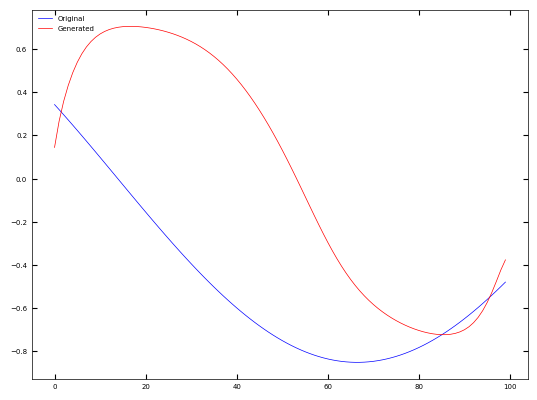

In [14]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


## Generating Validation Data

- We want to generate a hyperspectral image
- This can be done by taking the RGB values of an image and using them as parameters for a function


### Loads and image of my dog Nala

- Painting by _Irene Dogmatic_


In [15]:
# Loads dog image

image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image

image = image[200:1900:20, 100:1500:20] / 255


### Displays the image


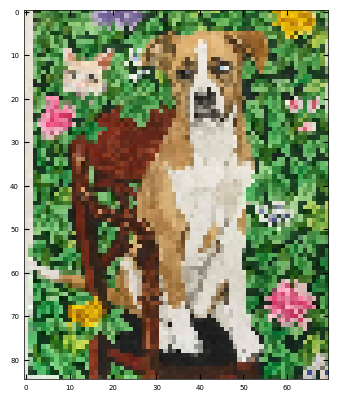

In [16]:
plt.imshow(image)


### Generates the data from RGB sampling


In [17]:
# Converts the image into parameters within the generated range

nala_params = np.atleast_3d(image.reshape(-1, 3))

nala_amp = torch.tensor(nala_params[:, 0, 0] * 0.8 + 0.2)
nala_phase = torch.tensor(nala_params[:, 1, 0] * 2 * np.pi)
nala_frequency = torch.tensor(nala_params[:, 2, 0] * 0.5 + 0.1)

_nala_params = torch.torch.stack((nala_amp, nala_phase, nala_frequency))

_nala_params = torch.atleast_3d(_nala_params)
_nala_params = torch.transpose(_nala_params, 0, 1)


In [18]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


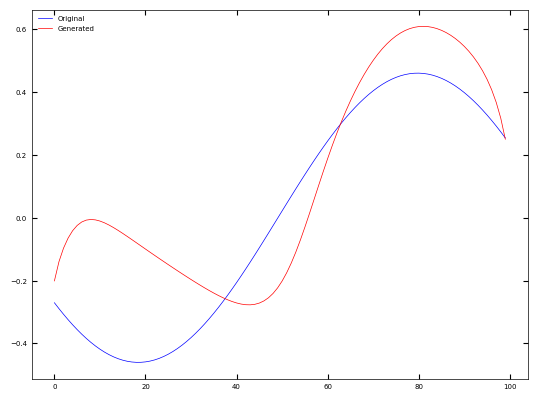

In [19]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


### Visualize the learned results


In [20]:
# Visualize the learned embeddings
embeddings(nala_encoded_, shape_=image.shape[0:2], figsize=(5, 1.25))


NameError: name 'embeddings' is not defined

In [ ]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(5, 1.25))


- **There is minimal resemblance to the true features**

- This is unsurprising because there are no rules that define what the embedding should look like.


## Let's try a bigger model

### Builds the model


In [ ]:
device = "cuda"
latent_dim = 12

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [ ]:
# views the model

model


## Training


In [ ]:
# trains the model

torch.manual_seed(0)
Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


### Visualize the reconstruction


In [ ]:
# computes an example reconstruction for a minibatch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


In [ ]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


- Reconstruction is slightly better but just more overfit


### Visualize the learned results


In [ ]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


In [ ]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


In [ ]:
# Visualize the learned embeddings

embeddings(nala_encoded_, shape_=image.shape[0:2], figsize=(5, 3))


In [ ]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(4, 1.25))


- **Now there are just more features but no resemblance between the parameters.**
- It would be impossible to have any resemblance to the features since it is overcomplete.


## Physics constrained neural network

### Building the model


In [ ]:
class DensePhysLarger(nn.Module):
    def __init__(
        self,
        x_vector,
        model,
        dense_params=3,
        verbose=False,
        device="cuda",
        num_channels=1,
        **kwargs
    ):
        """

        Args:
            x_vector: The vector of values for x
            model: the empirical function to fit
            dense_params: number of output parameters to the model
            verbose: sets if the model is verbose
            device: device where the model will run
            num_channels: number of channels in the input
        """

        super().__init__()
        self.dense_params = dense_params
        self.x_vector = x_vector
        self.verbose = verbose
        self.num_channels = num_channels
        self.device = device
        self.model_params = kwargs.get("model_params")
        # (self.x_vector, size=(num_channels, dense_params // self.model_params))
        self.model = model
        self.sigmoid = nn.Sigmoid()
        n = 4

        if torch.cuda.is_available():
            self.cuda()

        # Input block of 1d convolution

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.num_channels,
                      out_channels=8 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8 * n, out_channels=6 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6 * n, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        self.hidden_x1_shape = self.hidden_x1(
            torch.zeros(1, self.num_channels, self.x_vector.shape[0])
        ).shape

        # fully connected block

        self.hidden_xfc = nn.Sequential(
            nn.Linear(self.hidden_x1_shape[1] * self.hidden_x1_shape[2], 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # out of size 20

        self.hidden_xfc_shape = self.hidden_xfc(
            torch.zeros(1, self.hidden_x1_shape[1] * self.hidden_x1_shape[2])
        ).shape

        # 2nd block of 1d-conv layers

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=1, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4 * n, out_channels=2 * n, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2 * n, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        self.hidden_x2_shape = self.hidden_x2(
            torch.zeros(
                (
                    self.hidden_xfc_shape[0],
                    1,
                    self.hidden_x1_shape[1] * self.hidden_x1_shape[2],
                )
            )
        ).shape

        # Flatten layer

        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear

        self.hidden_embedding = nn.Sequential(
            nn.Linear(
                self.hidden_x2_shape[1] * self.hidden_x2_shape[2]
                + self.hidden_xfc_shape[1],
                16,
            ),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.dense_params),
        )

    def forward(self, x, n=-1):

        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (x.shape[0], -1))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(
            x, (x.shape[0], 1, self.hidden_x1_shape[1]
                * self.hidden_x1_shape[2])
        )
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.

        embedding = self.hidden_embedding(encoded)  # output is 3 parameters

        embedding = torch.reshape(embedding, (embedding.shape[0], 3, -1))

        embedding[:, 0, :] = (
            embedding[:, 0, :] * self.model.amp_sd + self.model.amp_mean
        )
        embedding[:, 1, :] = (
            embedding[:, 1, :] * self.model.phase_sd + self.model.phase_mean
        )
        embedding[:, 2, :] = (
            embedding[:, 2, :] * self.model.frequency_sd +
            self.model.frequency_mean
        )

        embedding = torch.reshape(embedding, (embedding.shape[0], -1))

        embedding = torch.abs(embedding)
        self.embed = embedding

        (out, _) = self.model.compute(embedding, device=self.device)

        out = torch.transpose(out, 1, 2)
        out = torch.atleast_3d(out)

        return (out.to(self.device), embedding.to(self.device))


In [ ]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()


### Dataloader


In [ ]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)


### Training


In [ ]:
random_seed(seed=42)

loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))


### Validation


In [ ]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


In [ ]:
nala_spectra_generated, nala_params = model(
    nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [ ]:
# removes 2pi shifts
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


In [ ]:
# Visualize the learned embeddings
embeddings(nala_params.detach().cpu().numpy(),
           shape_=image.shape[0:2], figsize=(5, 1.25))


In [ ]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(5, 1.25))


- **results are much closer to the underlying physics since we enforced them**
- The middle parameter is the phase. This is the hardest to learn $\rightarrow$ this makes sense


## Try with a better optimizer AdaHessian

- There are better optimizers than ADAM that use second-order information


In [ ]:
"""
Created on Sun Feb 26 16:34:00 2021
@author: Amir Gholami
@coauthor: David Samuel
"""

import numpy as np
import torch


class AdaHessian(torch.optim.Optimizer):
    """
    Implements the AdaHessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"
    Arguments:
        params (iterable) -- iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional) -- learning rate (default: 0.1)
        betas ((float, float), optional) -- coefficients used for computing running averages of gradient and the squared hessian trace (default: (0.9, 0.999))
        eps (float, optional) -- term added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay (float, optional) -- weight decay (L2 penalty) (default: 0.0)
        hessian_power (float, optional) -- exponent of the hessian trace (default: 1.0)
        update_each (int, optional) -- compute the hessian trace approximation only after *this* number of steps (to save time) (default: 1)
        n_samples (int, optional) -- how many times to sample `z` for the approximation of the hessian trace (default: 1)
    """

    def __init__(
        self,
        params,
        lr=0.1,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0.0,
        hessian_power=1.0,
        update_each=1,
        n_samples=1,
        average_conv_kernel=False,
    ):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError(f"Invalid Hessian power value: {hessian_power}")

        self.n_samples = n_samples
        self.update_each = update_each
        self.average_conv_kernel = average_conv_kernel

        # use a separate generator that deterministically generates the same `z`s across all GPUs in case of distributed training
        self.generator = torch.Generator().manual_seed(2147483647)

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            hessian_power=hessian_power,
        )
        super(AdaHessian, self).__init__(params, defaults)

        for p in self.get_params():
            p.hess = 0.0
            self.state[p]["hessian step"] = 0

    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """

        return (
            p for group in self.param_groups for p in group["params"] if p.requires_grad
        )

    def zero_hessian(self):
        """
        Zeros out the accumulated hessian traces.
        """

        for p in self.get_params():
            if (
                not isinstance(p.hess, float)
                and self.state[p]["hessian step"] % self.update_each == 0
            ):
                p.hess.zero_()

    @torch.no_grad()
    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """

        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if (
                self.state[p]["hessian step"] % self.update_each == 0
            ):  # compute the trace only for each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if (
            self.generator.device != params[0].device
        ):  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(
                params[0].device).manual_seed(2147483647)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            zs = [
                torch.randint(0, 2, p.size(),
                              generator=self.generator, device=p.device)
                * 2.0
                - 1.0
                for p in params
            ]  # Rademacher distribution {-1.0, 1.0}
            h_zs = torch.autograd.grad(
                grads,
                params,
                grad_outputs=zs,
                only_inputs=True,
                retain_graph=i < self.n_samples - 1,
            )
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += (
                    h_z * z / self.n_samples
                )  # approximate the expected values of z*(H@z)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional) -- a closure that reevaluates the model and returns the loss (default: None)
        """

        loss = None
        if closure is not None:
            loss = closure()

        self.zero_hessian()
        self.set_hessian()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or p.hess is None:
                    continue

                if self.average_conv_kernel and p.dim() == 4:
                    p.hess = (
                        torch.abs(p.hess)
                        .mean(dim=[2, 3], keepdim=True)
                        .expand_as(p.hess)
                        .clone()
                    )

                # Perform correct stepweight decay as in AdamW
                p.mul_(1 - group["lr"] * group["weight_decay"])

                state = self.state[p]

                # State initialization
                if len(state) == 1:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of gradient values
                    state["exp_hessian_diag_sq"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of Hessian diagonal square values

                exp_avg, exp_hessian_diag_sq = (
                    state["exp_avg"],
                    state["exp_hessian_diag_sq"],
                )
                beta1, beta2 = group["betas"]
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(
                    p.hess, p.hess, value=1 - beta2
                )

                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                k = group["hessian_power"]
                denom = (
                    (exp_hessian_diag_sq / bias_correction2)
                    .pow_(k / 2)
                    .add_(group["eps"])
                )

                # make update
                step_size = group["lr"] / bias_correction1
                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss


### Builds the model


In [ ]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()


### Dataloader


In [ ]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)


### Training


In [ ]:
random_seed(seed=42)

loss_func = torch.nn.MSELoss()

# Use AdaHessian

optimizer = AdaHessian(model.parameters(), lr=0.1)

epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))


### Visualization


In [ ]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


In [ ]:
nala_spectra_generated, nala_params = model(
    nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [ ]:
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


In [ ]:
# Visualize the learned embeddings
embeddings(nala_params.detach().cpu().numpy(),
           shape_=image.shape[0:2], figsize=(5, 1.25))


In [ ]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(5, 1.25))


This is clearly the best result

- It is quite impressive that we can build a feed forward model to fit data to complex functions
- This is actually a very hard task for a neural network as frequency and phase are something that cannot be learned easily in convolutions
